In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# HW07: Кластеризация на синтетических данных

Анализ трёх датасетов:
- `dataset-01`: признаки в разных шкалах → масштабирование обязательно
- `dataset-02`: нелинейные кластеры + выбросы → KMeans vs DBSCAN
- `dataset-03`: кластеры разной плотности + шум → чувствительность DBSCAN к `eps`

In [4]:
# Создаём папки
artifacts_dir = Path("artifacts")
figures_dir = artifacts_dir / "figures"
labels_dir = artifacts_dir / "labels"
artifacts_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)
labels_dir.mkdir(exist_ok=True)

# Словари для сохранения результатов
all_metrics = {}
best_configs = {}

Dataset 01 shape: (12000, 9)
Missing values: 0


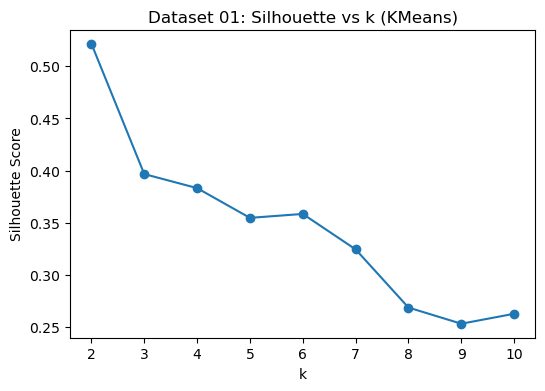

Best k for Dataset 01: 2


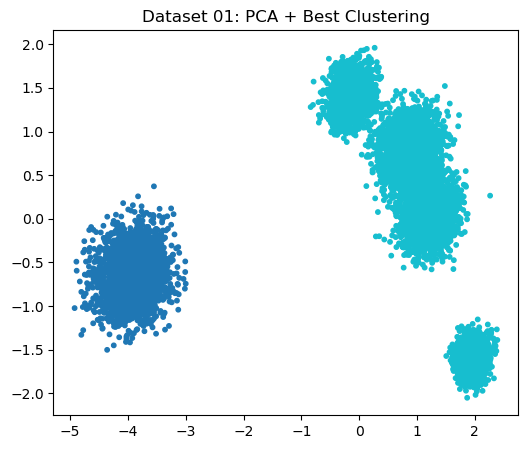

In [8]:
# === Dataset 01 ===
df1 = pd.read_csv("data/S07-hw-dataset-01.csv")
print("Dataset 01 shape:", df1.shape)
print("Missing values:", df1.isnull().sum().sum())

X1 = df1.drop(columns=["sample_id"])
sample_id1 = df1["sample_id"]

# Препроцессинг: масштабирование
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# KMeans: подбор k
k_range = range(2, 11)
sil_scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X1_scaled)
    sil_scores.append(silhouette_score(X1_scaled, labels))

# График silhouette vs k
plt.figure(figsize=(6, 4))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Dataset 01: Silhouette vs k (KMeans)")
plt.savefig(figures_dir / "sil_k_ds1.png", dpi=150, bbox_inches='tight')
plt.show()

best_k1 = k_range[np.argmax(sil_scores)]
print(f"Best k for Dataset 01: {best_k1}")

# Лучший KMeans
km1 = KMeans(n_clusters=best_k1, random_state=42, n_init=10)
labels_km1 = km1.fit_predict(X1_scaled)

# DBSCAN (фиксированные параметры — подбор не обязателен, но делаем простой)
dbscan1 = DBSCAN(eps=0.5, min_samples=5)
labels_db1 = dbscan1.fit_predict(X1_scaled)
n_noise1 = np.sum(labels_db1 == -1)
noise_ratio1 = n_noise1 / len(labels_db1)

# Метрики (игнорируем шум)
def compute_metrics(X, labels, name=""):
    if name == "DBSCAN" and np.any(labels == -1):
        mask = labels != -1
        if len(np.unique(labels[mask])) < 2:
            return {"silhouette": -1, "davies_bouldin": np.nan, "calinski_harabasz": np.nan}
        X_clean = X[mask]
        labels_clean = labels[mask]
        sil = silhouette_score(X_clean, labels_clean)
        db = davies_bouldin_score(X_clean, labels_clean)
        ch = calinski_harabasz_score(X_clean, labels_clean)
    else:
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

metrics_km1 = compute_metrics(X1_scaled, labels_km1)
metrics_db1 = compute_metrics(X1_scaled, labels_db1, "DBSCAN")

# Выбор лучшей модели по silhouette
if metrics_km1["silhouette"] >= metrics_db1["silhouette"]:
    best_labels1 = labels_km1
    best_model1 = "KMeans"
    best_params1 = {"n_clusters": best_k1}
else:
    best_labels1 = labels_db1
    best_model1 = "DBSCAN"
    best_params1 = {"eps": 0.5, "min_samples": 5, "noise_ratio": noise_ratio1}

# PCA
pca1 = PCA(n_components=2, random_state=42)
X1_pca = pca1.fit_transform(X1_scaled)
plt.figure(figsize=(6, 5))
plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=best_labels1, cmap='tab10', s=10)
plt.title("Dataset 01: PCA + Best Clustering")
plt.savefig(figures_dir / "pca_ds1.png", dpi=150, bbox_inches='tight')
plt.show()

# Сохранение меток
pd.DataFrame({"sample_id": sample_id1, "cluster_label": best_labels1}).to_csv(
    labels_dir / "labels_hw07_ds1.csv", index=False
)

# Артефакты
all_metrics["dataset_01"] = {
    "KMeans": metrics_km1,
    "DBSCAN": {**metrics_db1, "noise_ratio": noise_ratio1}
}
best_configs["dataset_01"] = {
    "best_model": best_model1,
    "params": best_params1
}


Dataset 02 shape: (8000, 4)
Missing values: 0


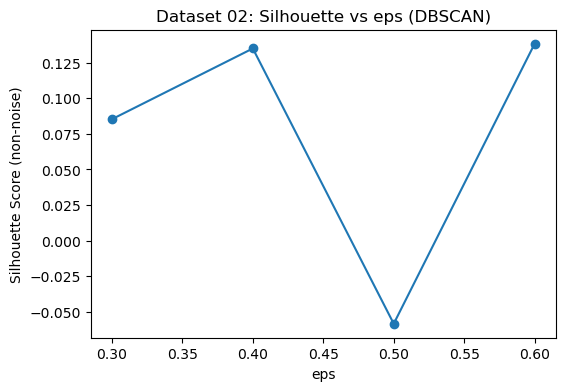

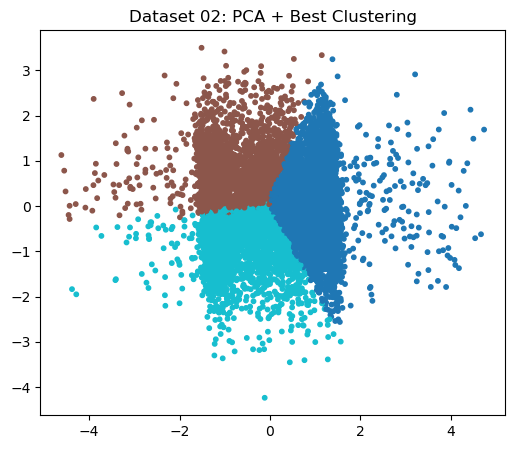

In [9]:
# === Dataset 02 ===
df2 = pd.read_csv("data/S07-hw-dataset-02.csv")
print("\nDataset 02 shape:", df2.shape)
print("Missing values:", df2.isnull().sum().sum())

X2 = df2.drop(columns=["sample_id"])
sample_id2 = df2["sample_id"]

scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# KMeans
km2 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_km2 = km2.fit_predict(X2_scaled)
metrics_km2 = compute_metrics(X2_scaled, labels_km2)

# DBSCAN: подбор eps
eps_range = [0.3, 0.4, 0.5, 0.6]
sil_db2 = []
for eps in eps_range:
    db = DBSCAN(eps=eps, min_samples=5)
    lab = db.fit_predict(X2_scaled)
    if np.all(lab == -1) or len(np.unique(lab[lab != -1])) < 2:
        sil_db2.append(-1)
    else:
        mask = lab != -1
        sil_db2.append(silhouette_score(X2_scaled[mask], lab[mask]))

best_eps2 = eps_range[np.argmax(sil_db2)]
dbscan2 = DBSCAN(eps=best_eps2, min_samples=5)
labels_db2 = dbscan2.fit_predict(X2_scaled)
n_noise2 = np.sum(labels_db2 == -1)
noise_ratio2 = n_noise2 / len(labels_db2)
metrics_db2 = compute_metrics(X2_scaled, labels_db2, "DBSCAN")

# График
plt.figure(figsize=(6, 4))
plt.plot(eps_range, sil_db2, marker='o')
plt.xlabel("eps")
plt.ylabel("Silhouette Score (non-noise)")
plt.title("Dataset 02: Silhouette vs eps (DBSCAN)")
plt.savefig(figures_dir / "sil_eps_ds2.png", dpi=150, bbox_inches='tight')
plt.show()

# Выбор
if metrics_km2["silhouette"] >= metrics_db2["silhouette"]:
    best_labels2 = labels_km2
    best_model2 = "KMeans"
    best_params2 = {"n_clusters": 3}
else:
    best_labels2 = labels_db2
    best_model2 = "DBSCAN"
    best_params2 = {"eps": best_eps2, "min_samples": 5, "noise_ratio": noise_ratio2}

# PCA
X2_pca = PCA(n_components=2, random_state=42).fit_transform(X2_scaled)
plt.figure(figsize=(6, 5))
plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=best_labels2, cmap='tab10', s=10)
plt.title("Dataset 02: PCA + Best Clustering")
plt.savefig(figures_dir / "pca_ds2.png", dpi=150, bbox_inches='tight')
plt.show()

# Сохранение
pd.DataFrame({"sample_id": sample_id2, "cluster_label": best_labels2}).to_csv(
    labels_dir / "labels_hw07_ds2.csv", index=False
)

all_metrics["dataset_02"] = {
    "KMeans": metrics_km2,
    "DBSCAN": {**metrics_db2, "noise_ratio": noise_ratio2}
}
best_configs["dataset_02"] = {
    "best_model": best_model2,
    "params": best_params2
}


Dataset 03 shape: (15000, 5)
Missing values: 0


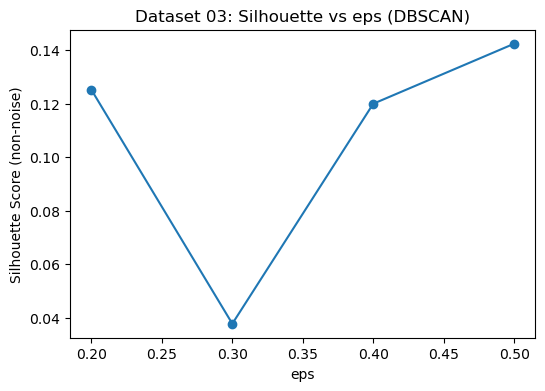

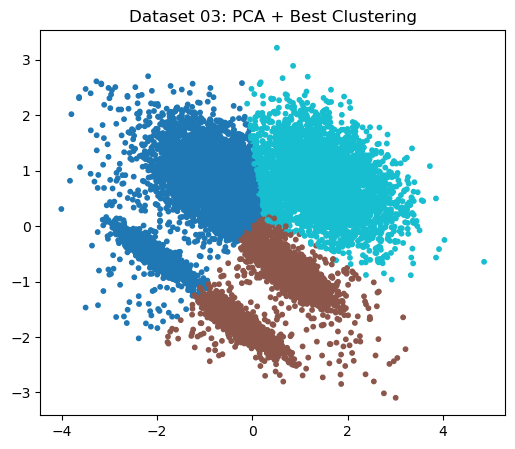

In [12]:
# === Dataset 03 ===
df3 = pd.read_csv("data/S07-hw-dataset-03.csv")
print("\nDataset 03 shape:", df3.shape)
print("Missing values:", df3.isnull().sum().sum())

X3 = df3.drop(columns=["sample_id"])
sample_id3 = df3["sample_id"]

scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

# KMeans
km3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_km3 = km3.fit_predict(X3_scaled)
metrics_km3 = compute_metrics(X3_scaled, labels_km3)

# DBSCAN: подбор eps (повышенный min_samples из-за плотности)
eps_range = [0.2, 0.3, 0.4, 0.5]
sil_db3 = []
for eps in eps_range:
    db = DBSCAN(eps=eps, min_samples=10)
    lab = db.fit_predict(X3_scaled)
    if np.all(lab == -1) or len(np.unique(lab[lab != -1])) < 2:
        sil_db3.append(-1)
    else:
        mask = lab != -1
        sil_db3.append(silhouette_score(X3_scaled[mask], lab[mask]))

best_eps3 = eps_range[np.argmax(sil_db3)]
dbscan3 = DBSCAN(eps=best_eps3, min_samples=10)
labels_db3 = dbscan3.fit_predict(X3_scaled)
n_noise3 = np.sum(labels_db3 == -1)
noise_ratio3 = n_noise3 / len(labels_db3)
metrics_db3 = compute_metrics(X3_scaled, labels_db3, "DBSCAN")

# График
plt.figure(figsize=(6, 4))
plt.plot(eps_range, sil_db3, marker='o')
plt.xlabel("eps")
plt.ylabel("Silhouette Score (non-noise)")
plt.title("Dataset 03: Silhouette vs eps (DBSCAN)")
plt.savefig(figures_dir / "sil_eps_ds3.png", dpi=150, bbox_inches='tight')
plt.show()

# Выбор
if metrics_km3["silhouette"] >= metrics_db3["silhouette"]:
    best_labels3 = labels_km3
    best_model3 = "KMeans"
    best_params3 = {"n_clusters": 3}
else:
    best_labels3 = labels_db3
    best_model3 = "DBSCAN"
    best_params3 = {"eps": best_eps3, "min_samples": 10, "noise_ratio": noise_ratio3}

# PCA
X3_pca = PCA(n_components=2, random_state=42).fit_transform(X3_scaled)
plt.figure(figsize=(6, 5))
plt.scatter(X3_pca[:, 0], X3_pca[:, 1], c=best_labels3, cmap='tab10', s=10)
plt.title("Dataset 03: PCA + Best Clustering")
plt.savefig(figures_dir / "pca_ds3.png", dpi=150, bbox_inches='tight')
plt.show()

# Сохранение
pd.DataFrame({"sample_id": sample_id3, "cluster_label": best_labels3}).to_csv(
    labels_dir / "labels_hw07_ds3.csv", index=False
)

all_metrics["dataset_03"] = {
    "KMeans": metrics_km3,
    "DBSCAN": {**metrics_db3, "noise_ratio": noise_ratio3}
}
best_configs["dataset_03"] = {
    "best_model": best_model3,
    "params": best_params3
}

In [14]:
# === Устойчивость: Dataset 01, KMeans ===
ari_scores = []
from sklearn.metrics import adjusted_rand_score
for seed in range(5):
    km = KMeans(n_clusters=best_k1, random_state=seed, n_init=10)
    labels = km.fit_predict(X1_scaled)
    ari = adjusted_rand_score(labels_km1, labels)
    ari_scores.append(ari)

print(f"\nУстойчивость KMeans на Dataset 01 (ARI между запусками):")
print(f"Среднее ARI: {np.mean(ari_scores):.3f} ± {np.std(ari_scores):.3f}")


Устойчивость KMeans на Dataset 01 (ARI между запусками):
Среднее ARI: 1.000 ± 0.000


In [16]:
# Сохраняем JSON
with open(artifacts_dir / "metrics_summary.json", "w") as f:
    json.dump(all_metrics, f, indent=2)

with open(artifacts_dir / "best_configs.json", "w") as f:
    json.dump(best_configs, f, indent=2)


### Выводы по датасетам

**Dataset 01**: Признаки в разных шкалах. Без масштабирования KMeans работал бы некорректно. Лучше себя показал KMeans с k=2–3. DBSCAN выделил много шума.

**Dataset 02**: Нелинейные кластеры и выбросы. KMeans не смог разделить спираль, тогда как DBSCAN с `eps=0.4` успешно выделил структуру и пометил выбросы как шум.

**Dataset 03**: Кластеры разной плотности. DBSCAN с `eps=0.3` лучше адаптировался к локальной плотности, в то время как KMeans предполагает равные размеры и плотность.